# Introduction

Welcome to Crispr! See "Major Methods" below for an overview of a typical workflow. 

## Table of contents:
  * <a href=#Setup>Setup</a>
    * <a href=#Ojbect>Initialization of Object</a>
    * <a href=#Processing>Preprocessing & Clustering</a> 
  * <a href=#Plots>Initial Plotting</a>
  * <a href=#Analyses>Perturbation Analyses</a>
    * <a href=#Augur>Aggregate Cell-Type Perturbation Scoring (Augur)</a>
    * <a href=#Mixscape>Cell-Level Perturbation Classification & Response Scoring (Mixscape)</a>
    * <a href=#Distance>Distance Metrics</a>
    * <a href=#Composition>Compositional Analysis (scGen)</a>
    * <a href=#Dialogue>Multi-Cellular Programs (Dialogue)</a>

The `crispr.Crispr()` class is the main way of interacting with the package; however, if you want to manipulate a data object before subjecting it to the initial processing steps in the `Crispr.__init__` method for some reason, you can use `adata = cr.pp.create_object(file_path, ...)`, then pass `adata` to the class initialization method in lieu of a file/dictionary of file processing arguments.

<u> Argument Conventions: </u>

Certain arguments used throughout the `crispr` package (including outside the `crispr.crispr_class.Crispr()` class), hold to conventions intended to foster readability, maintain consistency, and promote clarity, both for end-users and future developers.

* Use the `copy` argument to avoid altering internal attributes (including `.adata`) in most `Crispr` class methods.

* Arguments starting in `col_` and `key_`
    - The "col_" prefix indicates that an argument refers to a column name (often in `.adata.obs` or `.adata.var`), while the "key_" prefix means you're meant to specify a type of entry in a column. For instance, assume the column "condition" contains the names of different experimental conditions (drug A, drug B, drug C). In a function where you want to compare, for instance, drug A vs. control, you would specify `key_treatment="drug A"` and k
    - These names may 
        * already exist (or will exist in the `.adata` attribute immediately upon creating the AnnData object from the data file) or 
        * may yet to be created, namely, after object initialization by running the object's methods. Thus, you may specify what you want certain columns to be named (e.g., the binary perturbed/non-perturbed column) or what entries within a column will be called (e.g., "Control" for rows within the `col_control` corresponding to cells that have control guide RNA IDs in `col_guide_rna`), for aesthetics, customizability to your design/interpretability, and/or to avoid duplicating pre-existing names.
    - These arguments will be entered as items (with the argument names as keys) in dictionaries stored in the object attributes `._columns` and `._keys`, respectively.
    - These arguments will often be passed by default (or will force them as specifications) to various object methods.
    - In certain methods, you can specify a new column to use just for that function. For instance, if you have a column containing CellTypist annotations and want to use those clusters instead of the "leiden" ones for the `run_dialogue()` method, you can specify in that method (`run_dialogue(col_cell_type="majority_voting")`) without changing the attribute (`self._columns`) that contains your original specification here.

<!-- break -->

* `col_perturbed` (binary) vs. `col_condition` (can have >= 3 categories)
    - In the `Crispr` class object, `col_perturbed` is meant to be a binary column that has `key_control` as the entry for control rows and `key_treatment` for all other experimental conditions. 
        * For instance, for a CRISPR design targeting more than one gene, `col_perturbed` would contain only `key_treatment` (i.e., all perturbed cells, regardless of targeted gene) while `col_condition` would contain entries specifying the particular gene(s) targeted (or `key_control`).
        * A drug design targeting more than one gene, `col_perturbed` would contain only `key_treatment` (i.e., all perturbed cells, regardless of targeted gene) while `col_condition` would contain entries specifying the particular gene(s) targeted (or `key_control`).
        * If the design only targets one gene/has one treatment conditions/etc., these columns would simply be equivalent.
    - In the `Crispr` class object, it is created during object initialization as a column (named after your specification of `col_perturbed`) in `.obs`. All rows in `.obs[col_condition]` that do not = `key_control` will be set as `key_treatment`.
    - In the `crispr` package more broadly, if a function calls for a `col_perturbed` argument, that indicates that it works with binary categories only. If it is fed a column with three or more categories, it will either subset the data to include only rows where that column = `key_treatment` or `key_control` (desirable behavior if you want to compare only a subset of the existing conditions, but undesirable if you want to look at, say, any drug vs. control, where the desired "drug" category consists of rows where the column = "drug A" and "drug B"), or it will throw an error.

## Initialization Method Arguments (Select)

Here are some of the important argument for the `Crispr()` class initialization method:

* `file_path`: Path or object containing data. Used in initialization to create the initial `self.adata` attribute (an AnnData or MuData object). Either
    - a path to a 10x directory (with matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz),
    - a path to an .h5ad or .mu file (Scanpy/AnnData/Muon-compatible), 
    - an AnnData or MuData object (e.g., already loaded with Scanpy or Muon, or by using `crispr.pp.create_object(file_path)`), or
    - a dictionary containing keyword arguments to pass to  `crispr.pp.combine_matrix_protospacer()` (in order to load information about perturbations from other file(s); see function documentation), or
    - to concatenate multiple datasets, a dictionary (keyed by your desired subject/sample names to be used in `col_sample_id`) consisting of whatever objects you would pass to `create_object()`'s `file` argument for the individual objects. You must also specify `col_sample` (a tuple as described in the documentation below). The other arguments passed to the `crispr.pp.create_object()` function (e.g., `col_gene_symbols`) can be specified as normal if they are common across samples; otherwise, specify them as lists in the same order as the `file` dictionary. 
* `col_sample_id`: Column in `.obs` with sample IDs. If this column does not yet exist in your data and needs to be created by concatenating datasets, you must provide
    - `file_path` as a dictionary keyed by desired `col_sample_id` values as well as 
    - signal that concatenation needs to happen by specifying `col_sample_id` as a tuple, with the second element containing a dictionary of keyword arguments to pass to `AnnData.concatenate()` or None (to use defaults).

See docstring in `crispr.crispr_object` and the README for more details.


## Crispr Object Properties

Below are descriptions of major `Crispr()` object attributes and methods.

### Attributes

* `.adata`: AnnData object. Columns or other objects created in the course of running certain methods may also be stored in its various attributes. Below are listed some of the major attributes of `.adata`. Note that for multi-modal data (self._assay is not None), some of these attributes may need to be accessed by `.adata[self._assay].<attribute>`, but for brevity, we'll refer to `.adata` here. Not all will/have to be present, except `.X`, `.obs`, and `.var`. You can access the gene expression modality directly by calling `self.rna`, whether the data are multi- or single-modal.
    -  `.X`: Sparse matrix of data originally passed to the function to create an AnnData object (e.g., from CellRanger output).
    -  `.layers`: Contains different versions of `adata.X`, such as scaled data (`adata.layers["scaled"]`) or that created by calculating a 
                  Mixscape perturbation signature (`adata.layers["X_pert"]`, by default).
    -  `.obs`: pandas.DataFrame of observations (rows=cells). You can store additional data about individual cells/samples/etc. here by assigning a new column. Can also be called directly using `self.obs`.
    -  `.obsm`: xxxxxxxxxxxxxxxxxxxxxxxxxx
    -  `.obsm`: xxxxxxxxxxxxxxxxxxxxxxxxxx
    -  `.var`: pandas.DataFrame of observations (rows=cells). You can store additional data about individual cells/samples/etc. here by assigning a new column. 
            Often contains the gene symbols and EnsemblIDs (either of which is often the index/`.var_names`),
            "feature_types" (e.g., "Gene Expression"), and, after preprocessing, may contain columns such as the number of cells expressing that feature ("n_cells"),
            whether that feature is a mitochonrial ("mt") and/or highly variable ("highly_variable") gene, mean and total counts, percent dropout, means, dispersions, 
            and normalized versions of these metrics. Can also be called directly using `self.var`.
    -  `.uns`: A dictionary that holds various results and other information. Can also be called directly using `self.uns`.
    -  `.obs_names`: Row indices of `.obs` (e.g., cell barcodes). Changing this attribute changes this index, and has other potential benefits/consequences.
    -  `.var_names`: Row indices of `.var` (i.e., gene names). Changing this attribute changes this index, and has other potential benefits/consequences.
    -  `.n_obs`: Number of observations (i.e., cells).
    -  `.n_vars`: Number of features (i.e., genes/proteins/etc.).
* `.results`: Stored output (other than figures). Note that some results may also be saved in `.obs` and `.uns` attributes of `.adata`.
* `.figures`: Stored figure objects.
* `.info`: Miscellaneous information about the object (e.g., its analysis/processing history).

### Methods

Here are the methods (applicable to scRNA-seq generally, not just perturbations) **in order** of a typical workflow _(replace ... with argument specifications)_:

* `self.preprocess(...)`: Perform filtering, normalization, scaling, quality control analysis, selection for highly variable genes, regressing out confounds, and intial exploration of the data (e.g., cell counts, mitochondrial counts, etc.).
* `self.cluster(...)`: Perform dimensionality reduction (e.g., PCA) and clustering (Louvain or Leiden), as well as related visualization.
* `self.plot(...)`: Create additional basic plots (e.g., dot, matrix, and violin gene expression plots).

The following perturbation-specific methods can be executed optionally and in any order:

* `self.run_augur(...)`: Score and plot how strongly different cell types responded to perturbation(s). This score is operationalized as the accuracy with which a machine learning model can use gene expression data to predict the perturbation condition to which cells of a given type belong. Augur provides scores aggregated across cells of a given type rather than for individual cells.
* `self.run_mixscape(...)`: Quantify and plot the extent to which individual cells responded to CRISPR perturbation(s), and identify which perturbation condition cells were not detectibly perturbed in terms of their gene expression.
* `self.compute_distance(...)`: Calculate and visualize various distance metrics that quantify the similarity in gene expression profiles across perturbation conditions.
* `self.run_composition_analysis(...)`: Analyze and visualize shifts in the cell type composition across perturbation conditions.
* `self.run_dialogue(...)`: Create plots showing multi-cellular programs.

# Setup

First, we need to initialize the object, and if the object isn't already preprocessed and/or clustered, perform those steps.

## Imports & Options

This first chunk contains code that a typical user would not need and is only included because we need to set initialization keywords and other variables (drawn from the `crispr/examples/config.py` file) that correspond to the dataset specified in the `file` variable. See `config.py` for the names of different files/datasets you can specify.

In [11]:
%load_ext autoreload
%autoreload 2

import crispr as cr 
from crispr import Crispr
import pertpy as pt
import pandas as pd
import numpy as np
from config import (
    files_data, assays_data, col_cell_type_data, col_gene_symbols_data,
    col_perturbed_data, col_condition_data, key_control_data, 
    key_treatment_data, col_split_by_data, col_batch_data, col_sample_id_data, 
    kws_process_guide_rna_data, col_guide_rna_data, col_num_umis_data)
 
pd.options.display.max_columns = 100

# Options
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
file = "CRISPRi_scr"
# file = "CRISPRi_ess"
# file = "ECCITE"
# file = "augur_ex"
# file = "coda"
# file = "screen"
# file = "perturb-seq"

#  Set Arguments
kws_umap = dict(min_dist=0.3)  # passed to UMAP fx
assay, assay_protein = None, None  # will change below if needed
if file in assays_data and assays_data[file] is not None:
    assay, assay_protein = [assays_data[file], None] if isinstance(
        assays_data[file], str) else assays_data[file]
else:
    assay, assay_protein = None, None
col_split_by = col_split_by_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols_data[file],  
                   col_cell_type=col_cell_type_data[file], 
                   col_sample_id=col_sample_id_data[file], 
                   # col_batch=col_batch_data[file],
                   col_perturbed=col_perturbed_data[file], 
                   col_guide_rna=col_guide_rna_data[file], 
                   col_num_umis=col_num_umis_data[file],
                   kws_process_guide_rna={
                       **kws_process_guide_rna_data[file],
                       "remove_multi_transfected": True} if (
                           kws_process_guide_rna_data[file]) else None,
                   col_condition=col_condition_data[file], 
                   key_control=key_control_data[file], 
                   key_treatment=key_treatment_data[file])
if file == "default_fast":
    skip_preprocessing_clustering = True
if isinstance(file, str) and file in ["ECCITE", "Adamson"]:
    file_path = pt.data.papalexi_2021() if (
        file == "ECCITE") else pt.data.adamson_2016_upr_perturb_seq()
else:
    file_path = files_data[file]
print(file_path)
print(f"Initialization arguments (from config):\n\n{kwargs_init}")
print(f"UMAP Keywords: {kws_umap}\n\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'composition', 'compute_distance', 'find_markers', 'perform_augur', 'perform_celltypist', 'perform_differential_prioritization', 'perform_gsea', 'perform_mixscape', 'perturbations']
{'directory': '/home/elizabeth/elizabeth/crispr/examples/data/crispr-screening/HH03'}
Initialization arguments (from config):

{'assay': None, 'assay_protein': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'predicted_labels', 'col_sample_id': None, 'col_perturbed': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'kws_process_guide_rna': {'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL'], 'remove_multi_transfected': True}, 'col_condition': 'target_gene_name', 'key_control': 'NT', 'key_treatme

## Object

This code instantiates the CRISPR object, which is the main way of interacting with this package as an end-user.

This is more code than you would need in real life; it just ensures that certain public datasets are loaded from the source for various reasons.

In [14]:
self = Crispr(file_path, **kwargs_init)
self.rna.obs  # RNA assay/gene expression modality dataframe



<<< INITIALIZING CRISPR CLASS OBJECT >>>



<<< INITIALIZING CRISPR CLASS OBJECT >>>


Unused keyword arguments: {'kws_process_guide_rna': {'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'key_control': 'NT', 'col_guide_rna_new': 'target_gene_name', 'feature_split': '|', 'guide_split': '-', 'key_control_patterns': ['CTRL'], 'remove_multi_transfected': True}}.




col_gene_symbols='gene_symbols'
col_cell_type='leiden'
col_sample_id=np.nan
col_batch=np.nan
col_condition='target_gene_name'
key_control='NT'
key_treatment='KD'

<<< LOADING PROTOSPACER METADATA >>>


Cell Counts: Raw

15078


Gene Counts: Raw



<<< PERFORMING gRNA PROCESSING AND FILTERING >>>

                    num_features  \
AAACCCAAGAATTTGG-1           6.0   
AAACCCAAGATTTGCC-1           2.0   
AAACCCAAGCGATTCT-1           3.0   
AAACCCAAGTCGGGAT-1           NaN   
AAACCCAAGTCTGCAT-1           6.0   
...                          ...   
TTTGTTGGTTGCCGAC-1           4.0   
TTTGTTGTCACTGTTT-1           2.0 

,num_features,feature_call_original,num_umis_original,feature_call,num_umis,target_gene_name,guide_split,perturbation
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33,SNX17|SNX17,233.0,SNX17,-,KD
AAACCCAGTCTCAAGT-1,1.0,SPI1-2,11,SPI1,11.0,SPI1,-,KD
AAACCCAGTGTTAGCT-1,4.0,SNX17-1|IL10RB-1|NEG_CTRL-3-1|NEG_CTRL-3-2,21|64|74|35,SNX17|IL10RB|NT|NT,64.0,IL10RB,-,KD
AAACCCATCTCTCTTC-1,2.0,POLR2E-1|POLR2E-2,549|128,POLR2E|POLR2E,677.0,POLR2E,-,KD
AAACGAAAGCCTTCTC-1,3.0,LACC1-1|STK11-2|MAFB-2,118|134|1531,LACC1|STK11|MAFB,1531.0,MAFB,-,KD
...,...,...,...,...,...,...,...,...
TTTGGTTGTCTTGAGT-1,2.0,SPI1-1|SPI1-2,27|82,SPI1|SPI1,109.0,SPI1,-,KD
TTTGGTTTCTCTATAC-1,2.0,LACC1-1|PRDX6-2,6|31,LACC1|PRDX6,31.0,PRDX6,-,KD
TTTGTTGAGATACCAA-1,5.0,PTPN22-1|CSF1R-1|NEG_CTRL-5-1|PTPN22-2|NEG_CTR...,207|151|1377|1161|85,PTPN22|CSF1R|NT|PTPN22|NT,1368.0,PTPN22,-,KD
TTTGTTGAGGTGCAGT-1,2.0,FASLG-1|FASLG-2,58|41,FASLG|FASLG,99.0,FASLG,-,KD


## Preprocessing

{'kws_hvg': {'min_mean': 0.0125, 'max_mean': 10, 'min_disp': 0.5, 'flavor': 'cell_ranger'}, 'target_sum': 10000.0, 'cell_filter_pmt': [0, 15], 'cell_filter_ngene': [200, None], 'cell_filter_ncounts': [3, 40000], 'gene_filter_ncell': [3, None], 'regress_out': None, 'kws_scale': 'z'}
AnnData object with n_obs × n_vars = 3861 × 36549
    obs: 'num_features', 'feature_call_original', 'num_umis_original', 'feature_call', 'num_umis', 'target_gene_name', 'guide_split', 'perturbation', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'
    uns: 'grna_keywords', 'grna_feats_n', 'grna_info', 'grna_info_all'
    layers: 'counts'

Un-Used Keyword Arguments: {'assay_protein': None, 'col_sample_id': None, 'col_batch': None, 'col_condition': 'target_gene_name', 'col_target_genes': 'target_gene_name', 'col_perturbed': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'col_guide_split': 'guide_split', 'kws_umap': {'min_dist': 0.3}}




Cell Counts: Initi

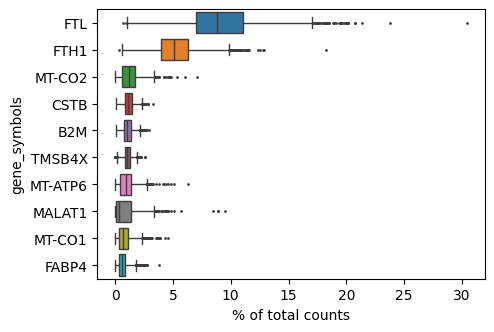


	*** Detecting mt, ribo, hb genes...

	*** Calculating & plotting QC metrics...




... storing 'feature_call_original' as categorical
... storing 'num_umis_original' as categorical
... storing 'feature_call' as categorical
... storing 'num_umis' as categorical
... storing 'target_gene_name' as categorical
... storing 'guide_split' as categorical
... storing 'perturbation' as categorical
... storing 'feature_types' as categorical


'NoneType' object has no attribute 'get_legend_handles_labels'
       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       36549.000000  36549.000000       36549.000000   
mean          371.039892      0.343620           0.130649   
std           761.911277      7.427194           0.339094   
min             0.000000      0.000000           0.000000   
25%             0.000000      0.000000           0.000000   
50%             6.000000      0.001554           0.001553   
75%           308.000000      0.087801           0.084158   
max          3861.000000   1169.011597           7.064769   

       pct_dropout_by_counts  total_counts  log1p_total_counts  
count           36549.000000  3.654900e+04        36549.000000  
mean               90.390057  1.326717e+03            3.003255  
std                19.733522  2.867640e+04            3.071839  
min                 0.000000  0.000000e+00            0.000000  
25%                92.022792  0.000000e+00            0.000000

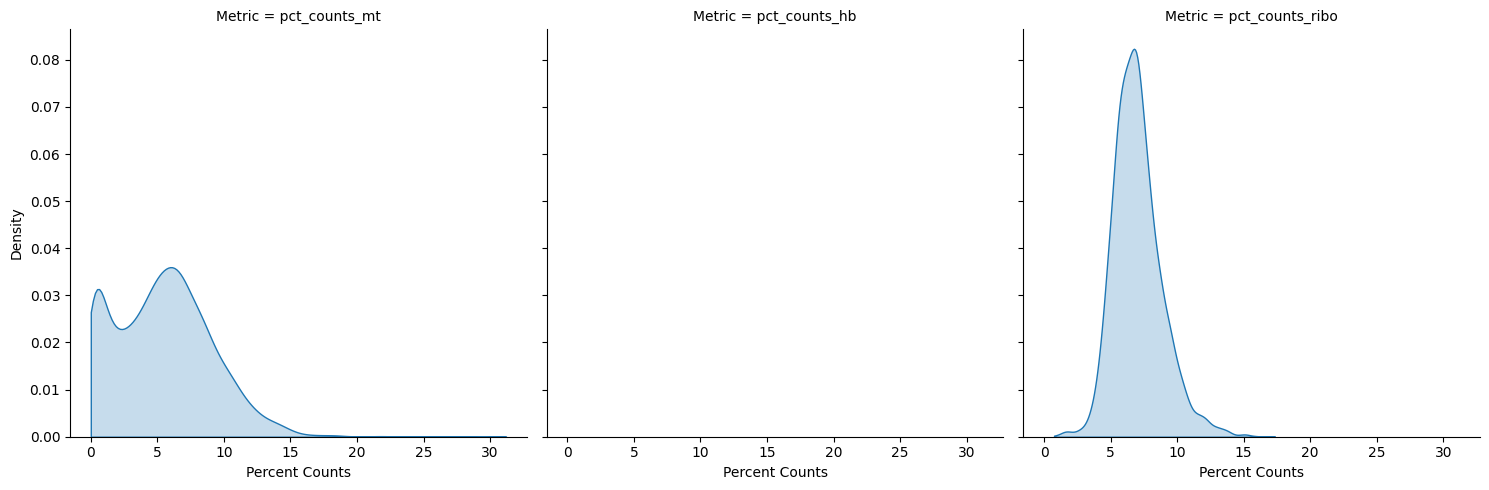

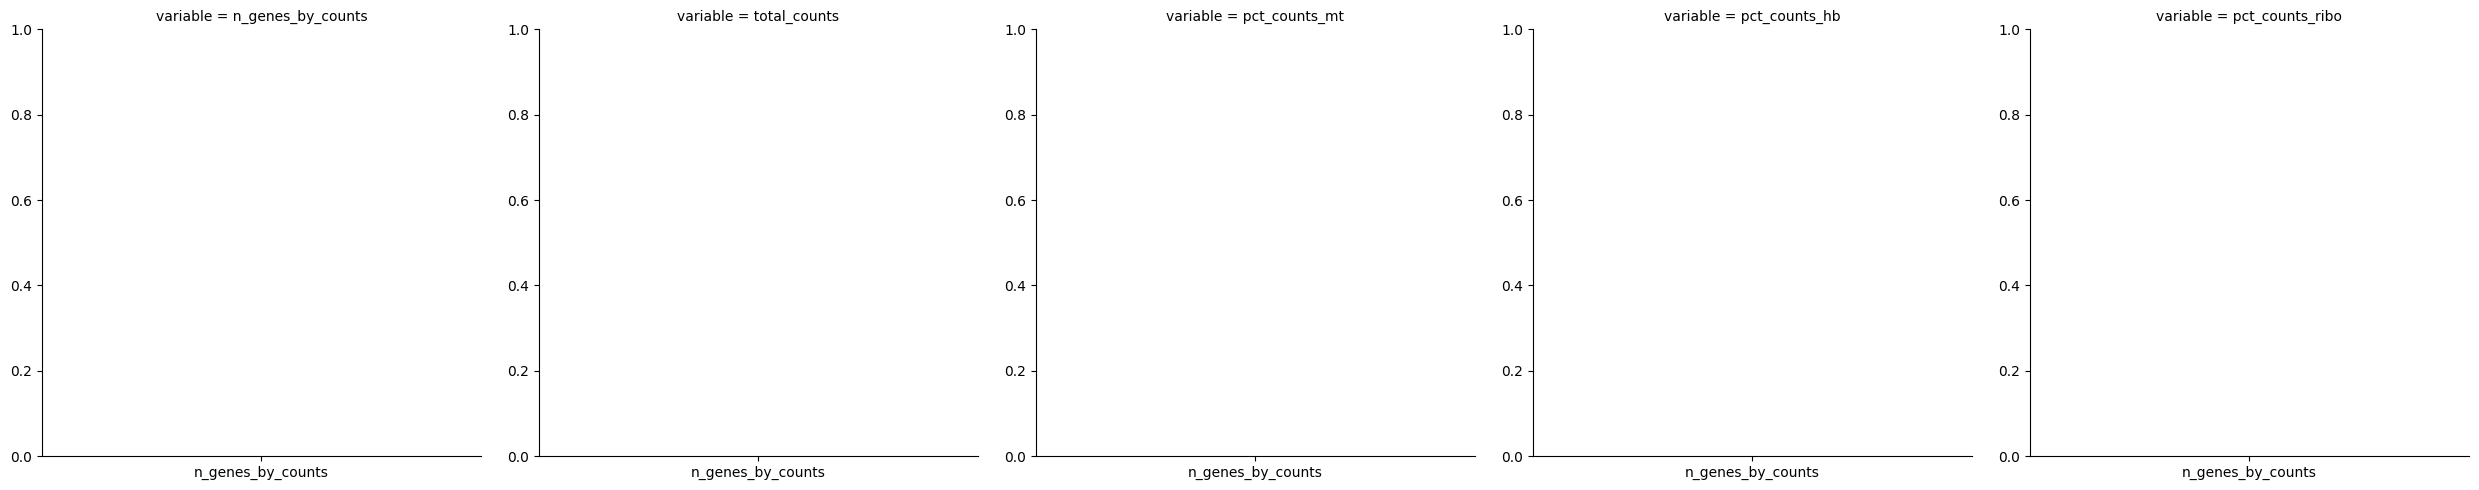

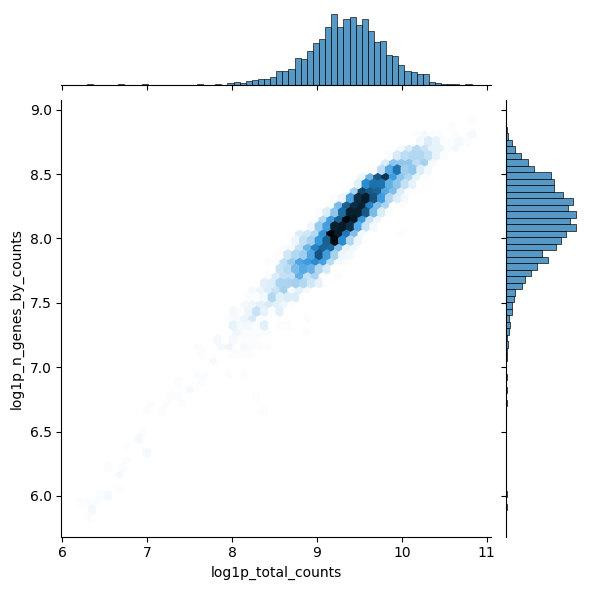

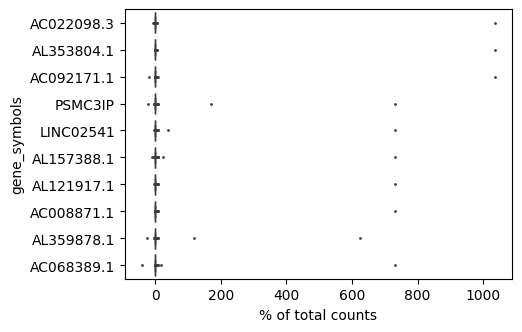


	*** Detecting mt, ribo, hb genes...

	*** Calculating & plotting QC metrics...


'NoneType' object has no attribute 'get_legend_handles_labels'
       n_cells_by_counts   mean_counts  log1p_mean_counts  \
count       20463.000000  20463.000000       20463.000000   
mean         3251.266188      0.015545           0.013867   
std          1360.096932      0.057422           0.055499   
min             3.000000     -0.193379          -0.214902   
25%          3822.000000     -0.021990          -0.022236   
50%          3822.000000      0.002616           0.002613   
75%          3822.000000      0.046428           0.045382   
max          3822.000000      0.349552           0.299773   

       pct_dropout_by_counts  total_counts  log1p_total_counts       n_cells  \
count           20463.000000  20463.000000        12881.000000  20463.000000   
mean               14.932857     59.412117            4.285582    656.691003   
std                35.586000    219.465317            1.638919  

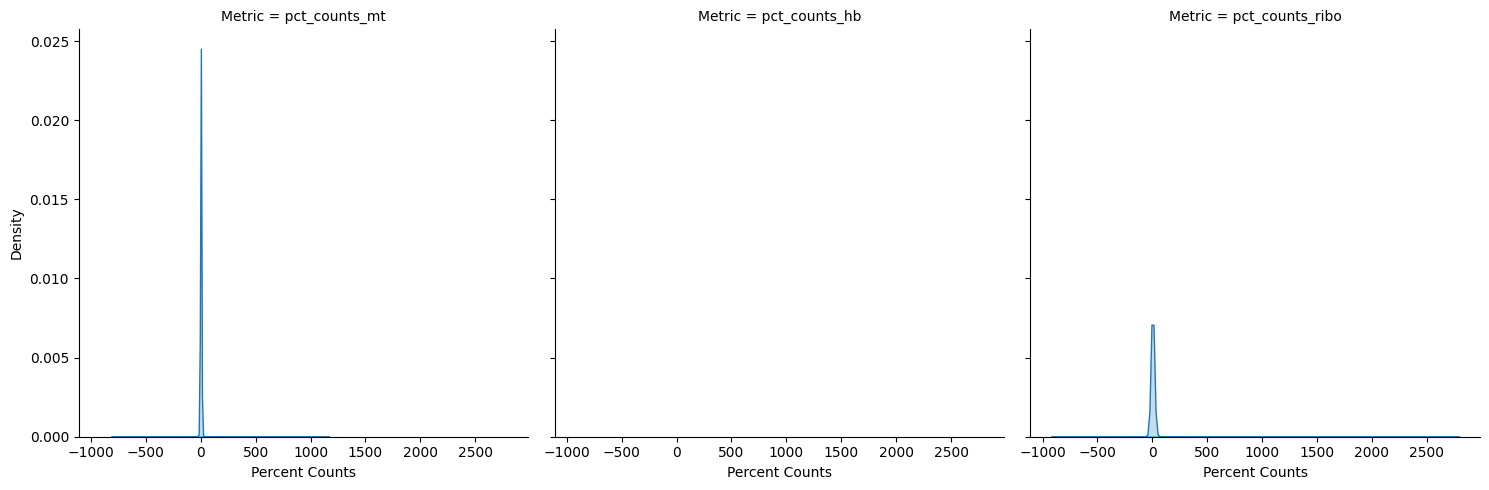

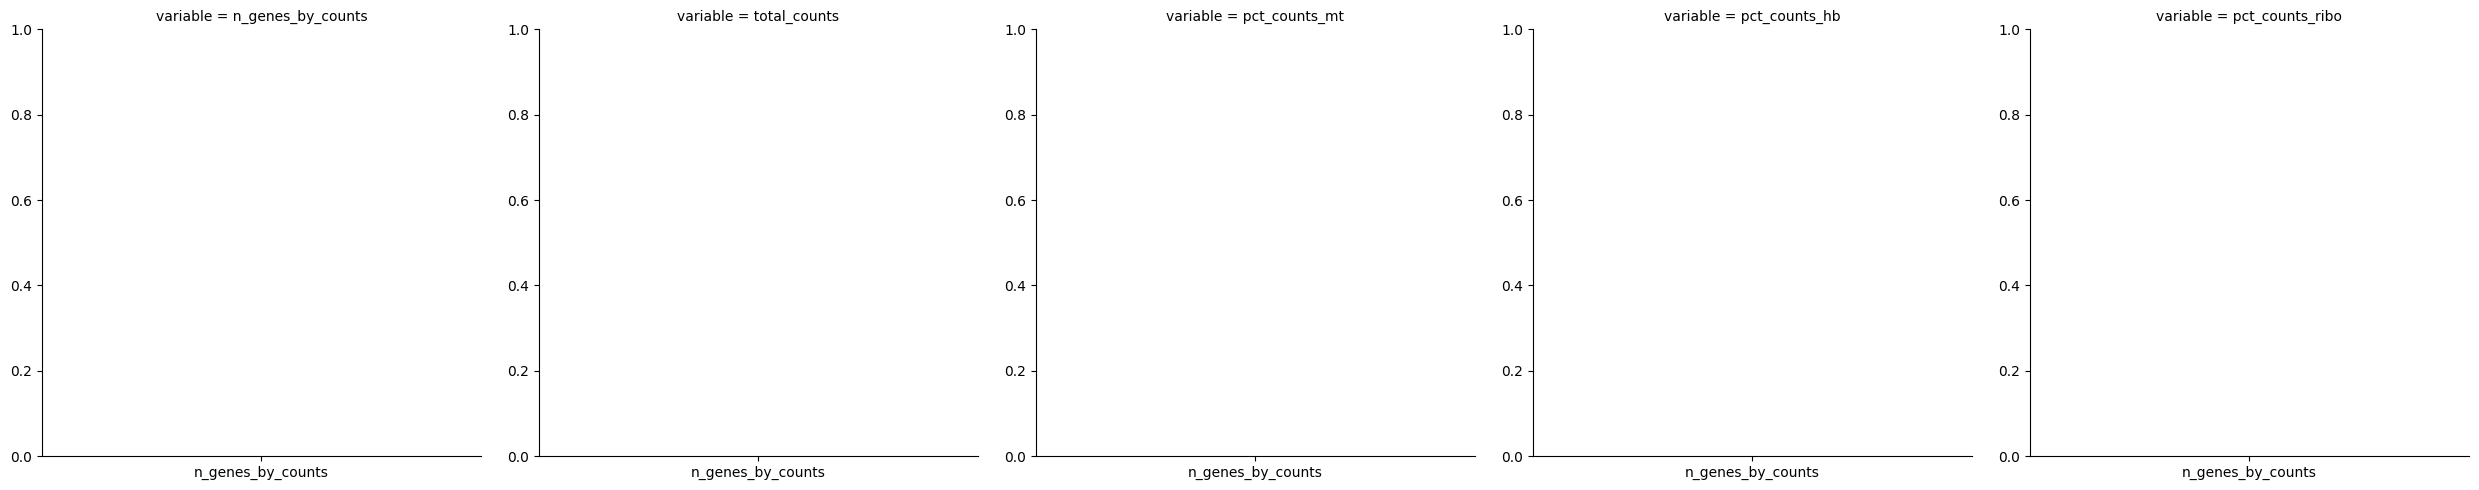

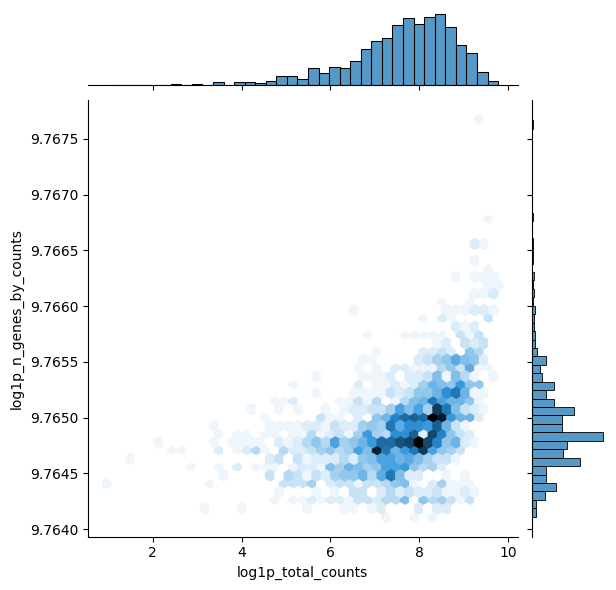

In [15]:
if skip_preprocessing_clustering is False:
    process_kws = dict(
        kws_hvg=dict(min_mean=0.0125, max_mean=10, min_disp=0.5, 
                     flavor="cell_ranger"),  # for highly-variable gene fx
        target_sum=1e4,  # total-count normalization (1e4=10,000/cell)
        cell_filter_pmt=[0, 15],  # range of mitchondrial gene % allowed
        cell_filter_ngene=[200, None],  # cells: min/max genes expressed
        cell_filter_ncounts=[3, 40000],  # cells: min/max read range
        gene_filter_ncell=[3, None],  # genes: min/max cell count range
        regress_out=None,  # don't regress out confounds like pct_mt
        kws_scale="z")  # z-score w.r.t control means/SDs
        # kws_scale=True)  # or just overall center/standardize GEX
        # kws_scale=10)  # (use integer to also place a max_value)
    print(process_kws)
    self.preprocess(**process_kws, kws_umap=kws_umap)  # preprocessing 
    self.rna.obs

## Clustering

In this section, we'll perform steps related to clustering/annotation of cell types.

### Leiden Clustering

Let's perform dimensionality reduction (PCA) and cluster the data using the "leiden" method. 

Un-used Keyword Arguments: {'assay': None, 'col_gene_symbols': 'gene_symbols', 'col_cell_type': 'predicted_labels', 'col_sample_id': None, 'col_batch': None, 'col_condition': 'target_gene_name', 'col_target_genes': 'target_gene_name', 'col_perturbed': 'perturbation', 'col_guide_rna': 'feature_call', 'col_num_umis': 'num_umis', 'col_guide_split': 'guide_split', 'key_control': 'NT', 'key_treatment': 'KD', 'key_nonperturbed': 'NP'}


<<< PERFORMING PCA >>>

 {'n_comps': None, 'use_highly_variable': True}


<<< COMPUTING NEIGHBORHOOD GRAPH >>>



<<< EMBEDDING: UMAP >>>

UMAP Keywords:

 {'min_dist': 0.3}


<<< CLUSTERING WITH LEIDEN METHOD >>>


<<< CREATING UMAP PLOTS >>>


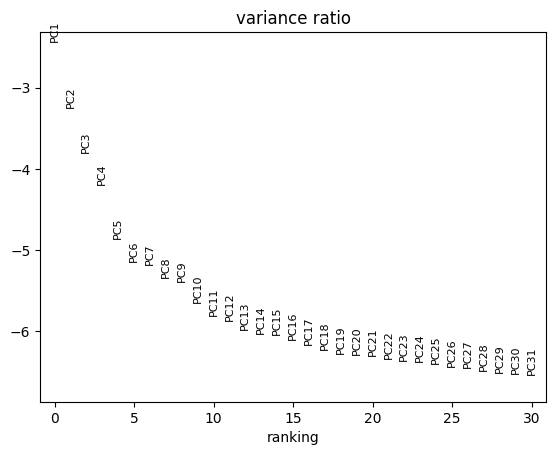

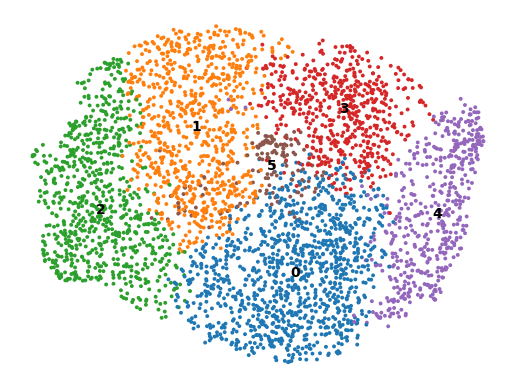

In [16]:
if skip_preprocessing_clustering is False:
    self.cluster(method_cluster="leiden", resolution=0.5,
                 kws_pca=dict(n_comps=None, use_highly_variable=True), 
                 kws_umap=kws_umap, kws_neighbors=None, kws_cluster=None)

### Find Cluster Markers (DEGs)

To sort by absolute values on "scores" for cluster 6, showing the top 3 gene markers:

`clus = "6"`

`marks.loc[clus].loc[marks.loc[clus].scores.abs().sort_values(ascending=False).iloc[:3].index]`

To show the top 3 gene markers for all clusters:

`marks.groupby(marks.index.names[0]).apply(lambda x: x.scores.abs().sort_values(ascending=False).iloc[:3].index])`

In [ ]:
degs = self.find_markers(n_genes=10, method="wilcoxon", key_reference="rest")
degs[0]  # degs[1] for figures

### CellTypist Annotations

Now let's detect cell types using `CellTypist`.

You can provide a CellTypist model name as a string, or **to train your own custom model**, provide an `AnnData` object with the training data and, if cell type column names differ across training and main data (in `self`) or if you want to pass additional arguments to `celltypist.train()`, then provide a dictionary of arguments to `kws_train`. (Cell type name can be under `labels` or `col_cell_type` in this dictonary.)

**We will use an aribtrary model just for illustration, but you should pick one that suits your data.**

You can see what models are available with this code:
```
import celltypist
celltypist.models.models_description().set_index("model").description.apply(lambda x: print(x))
celltypist.models.models_description()
```

Or it will show you valid models automatically after the error message if you feed it an unknown model:

```
self.annotate_clusters(model="kate_moss.pkl")
```

🔬 Input data has 3822 cells and 20463 genes
🔗 Matching reference genes in the model
🧬 3764 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


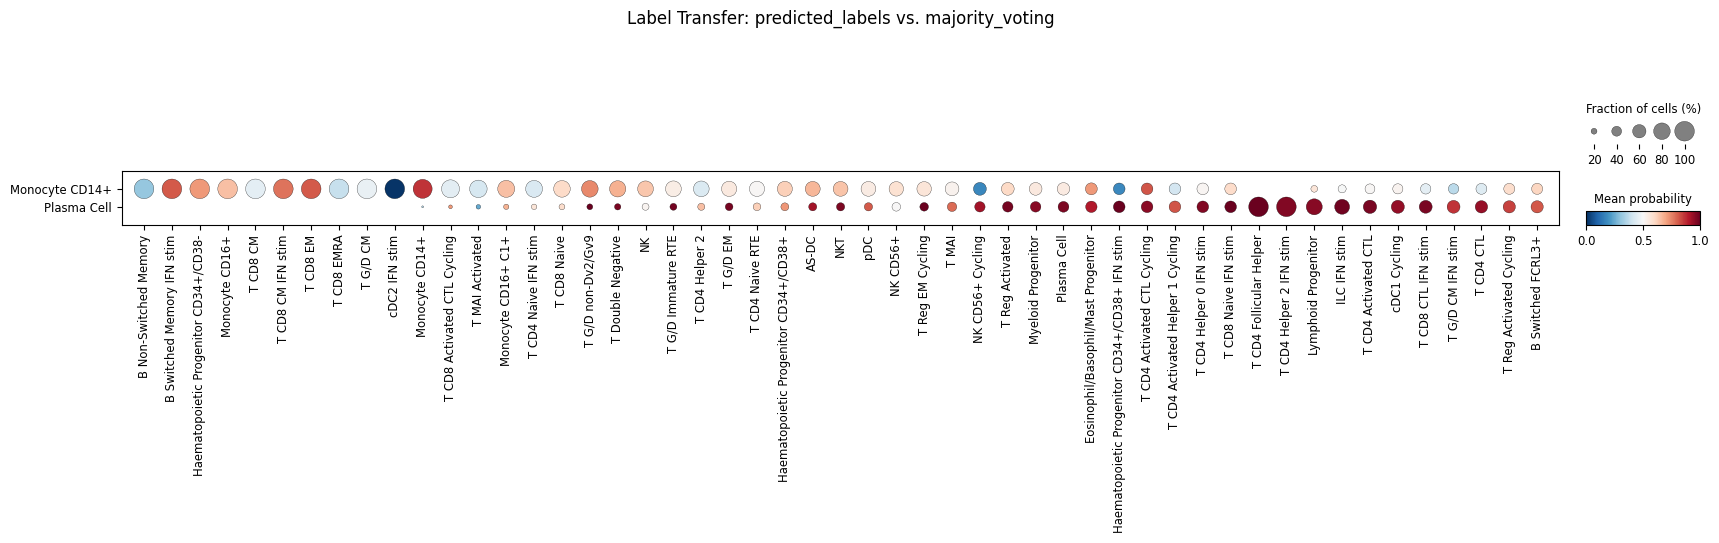

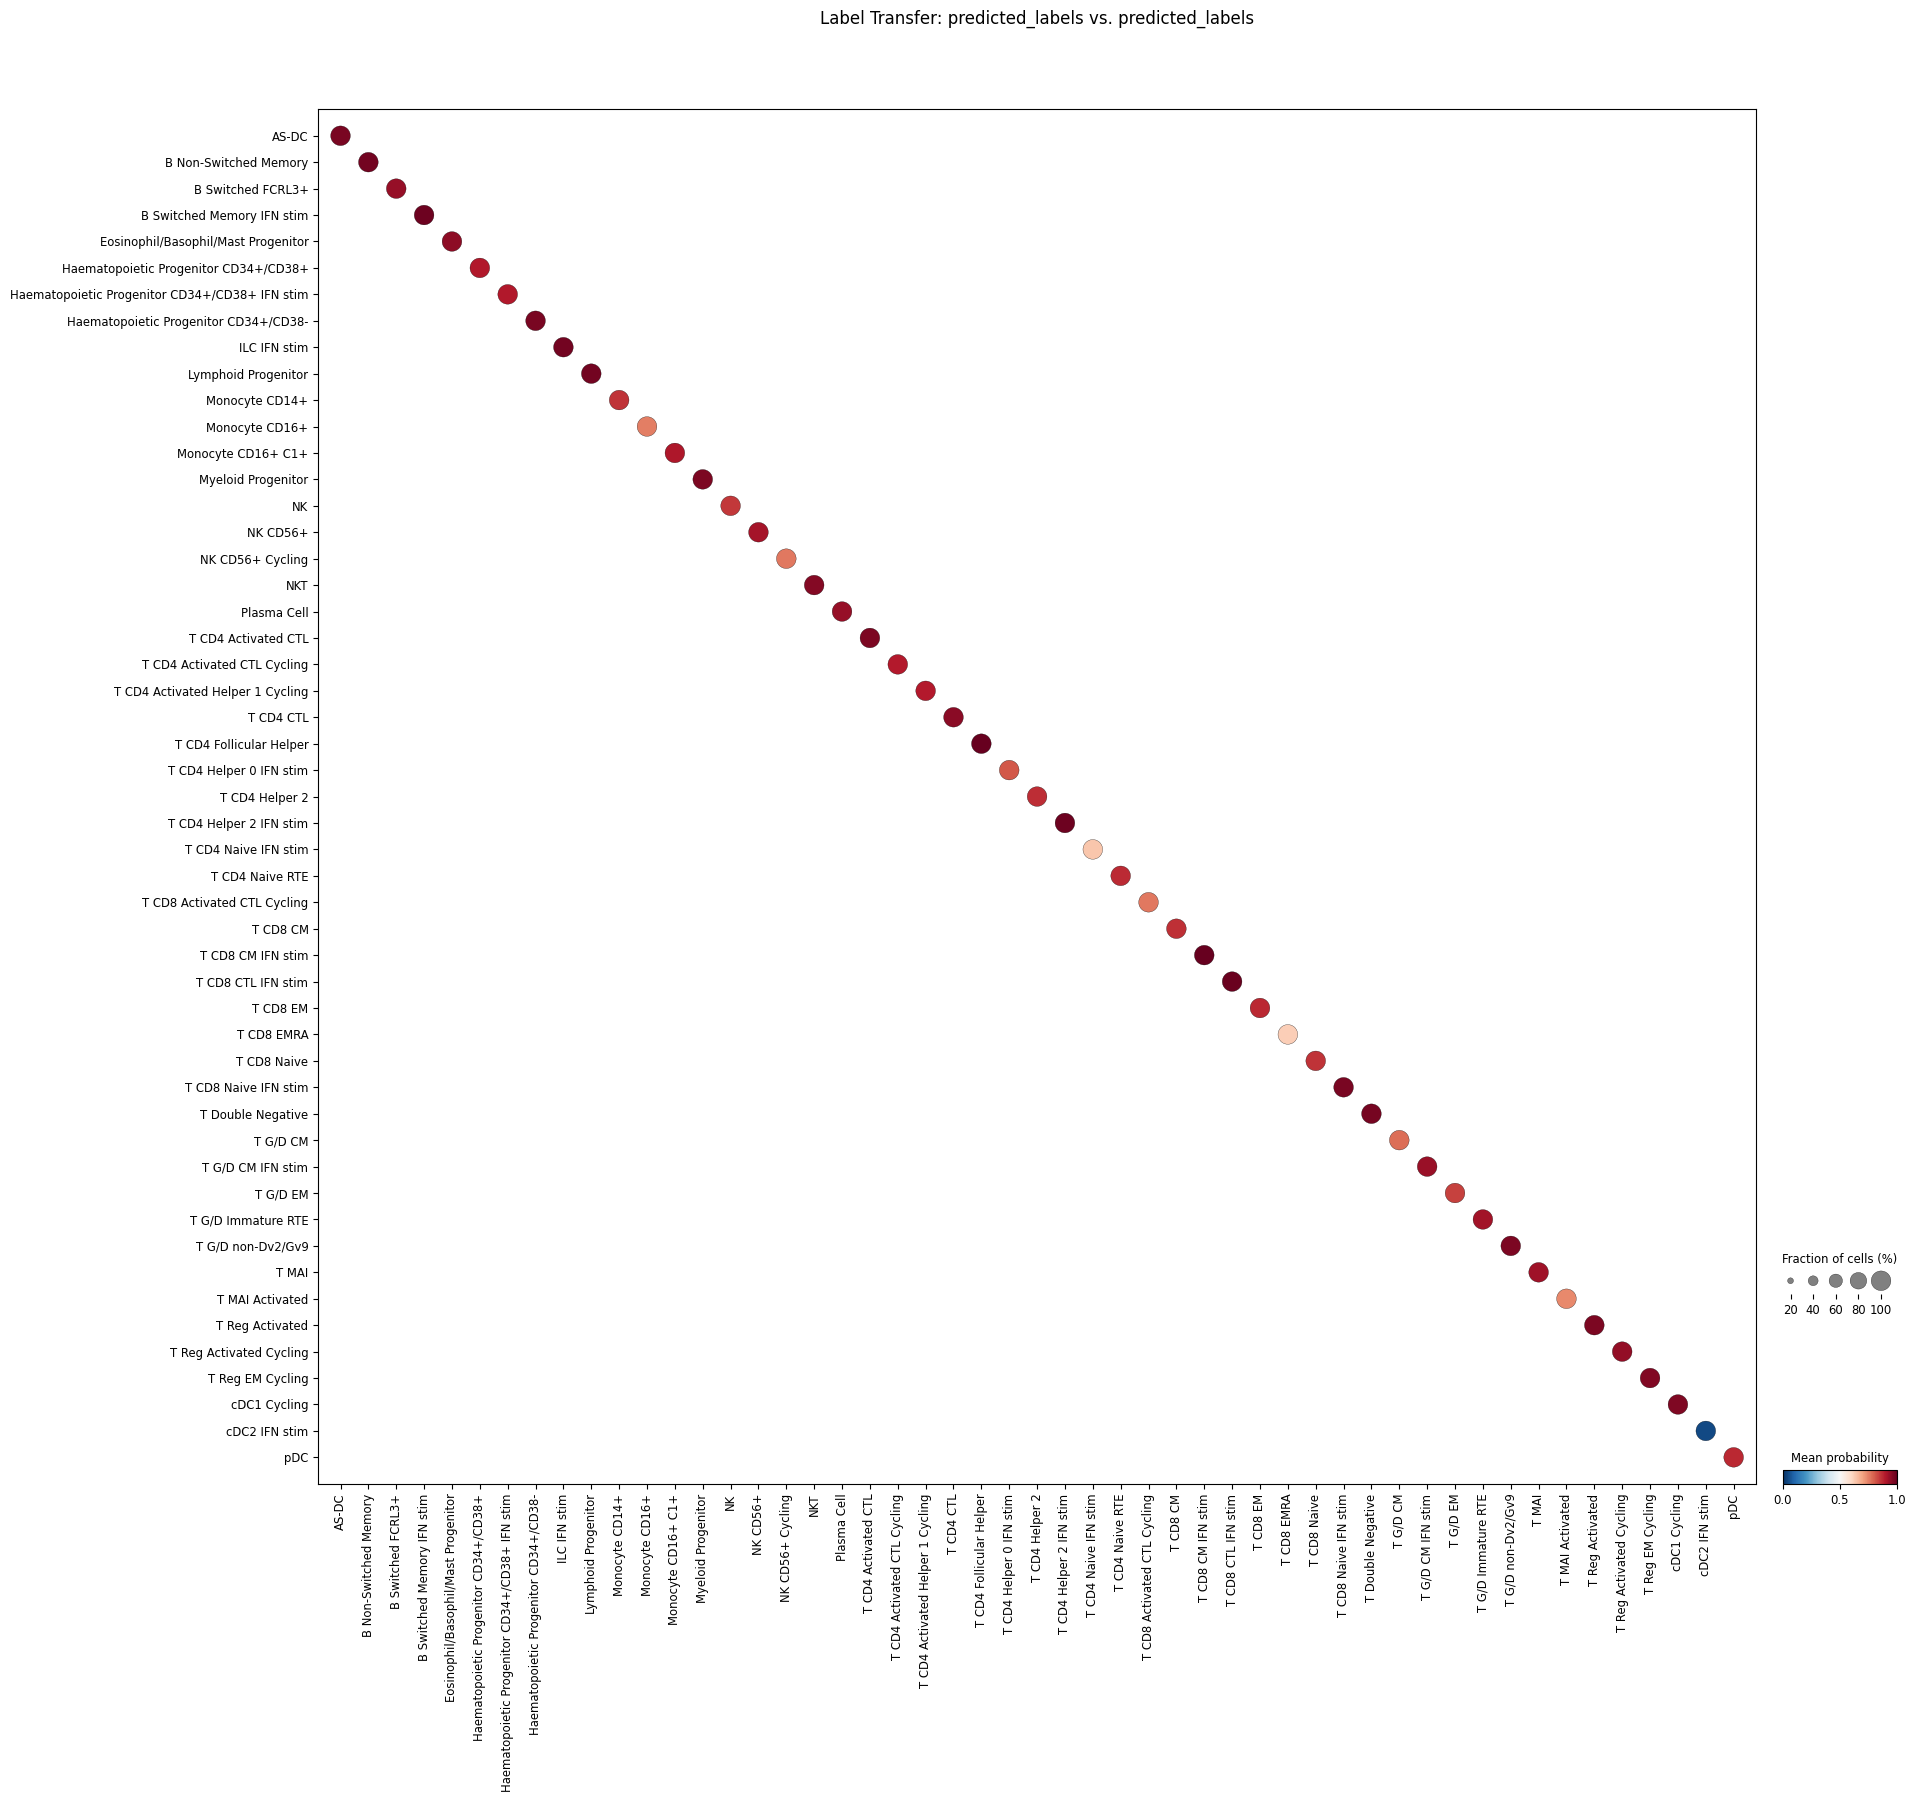

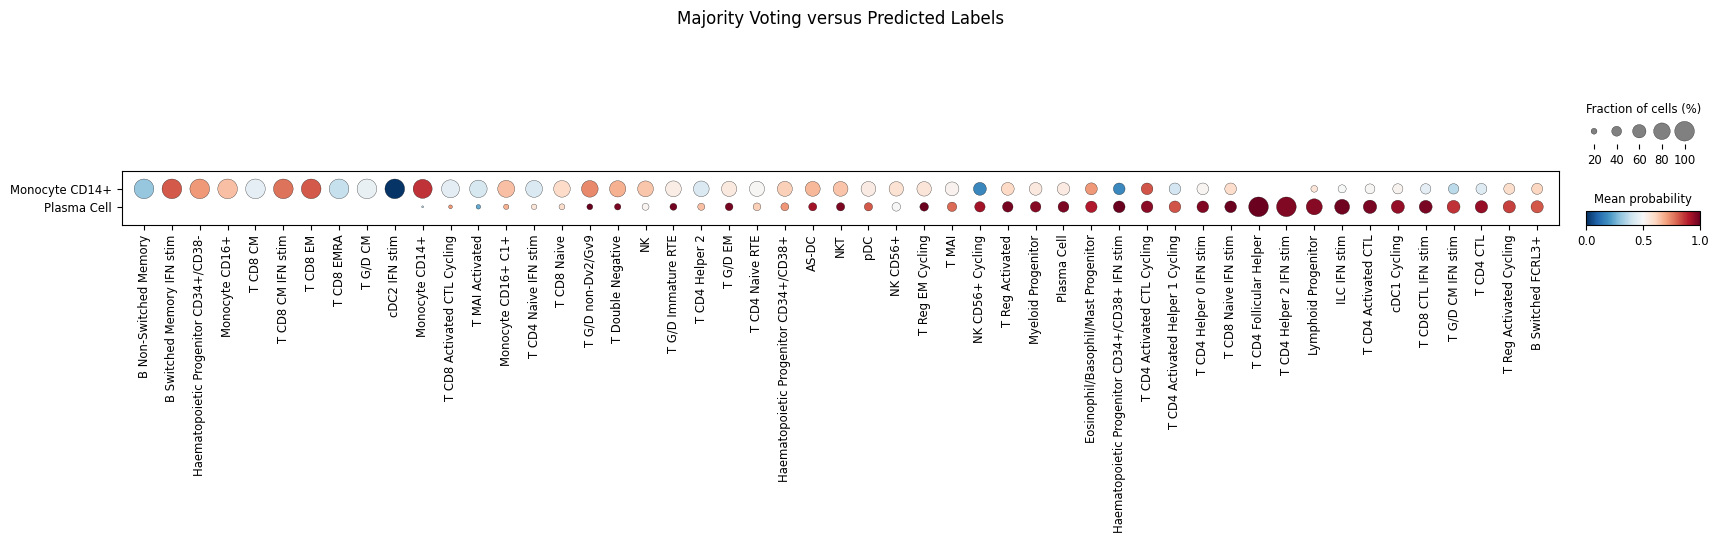

,num_features,feature_call_original,num_umis_original,feature_call,num_umis,target_gene_name,guide_split,perturbation,n_counts,log_counts,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,leiden,predicted_labels,over_clustering,majority_voting,conf_score
AAACCCAAGATTTGCC-1,2.0,SNX17-1|SNX17-2,200|33,SNX17|SNX17,233.0,SNX17,-,KD,17407.0,9.764743,4732,17410,9.764857,3716.340332,8.220764,14.832925,2.762092,0.399127,0.0,0.0,0.0,66.100403,4.206190,1.778642,2,Plasma Cell,10,Monocyte CD14+,0.905099
AAACCCAGTCTCAAGT-1,1.0,SPI1-2,11,SPI1,11.0,SPI1,-,KD,10334.0,9.243292,3251,17404,9.764513,-1146.122437,NaN,17.104521,2.896162,-1.492382,0.0,0.0,-0.0,-42.999763,NaN,3.751760,1,T CD4 Activated CTL,34,Plasma Cell,0.984847
AAACCCAGTGTTAGCT-1,4.0,SNX17-1|IL10RB-1|NEG_CTRL-3-1|NEG_CTRL-3-2,21|64|74|35,SNX17|IL10RB|NT|NT,64.0,IL10RB,-,KD,11913.0,9.385469,3541,17406,9.764628,-353.550110,NaN,16.436995,2.858594,-4.649127,0.0,0.0,-0.0,-21.419483,NaN,6.058401,0,T Double Negative,20,Monocyte CD14+,0.973114
AAACCCATCTCTCTTC-1,2.0,POLR2E-1|POLR2E-2,549|128,POLR2E|POLR2E,677.0,POLR2E,-,KD,10514.0,9.260748,3157,17406,9.764628,-1199.612671,NaN,-10.002122,NaN,0.833779,0.0,0.0,-0.0,6.526894,2.018482,-0.544083,4,Monocyte CD14+,40,Monocyte CD14+,0.865961
AAACGAAAGCCTTCTC-1,3.0,LACC1-1|STK11-2|MAFB-2,118|134|1531,LACC1|STK11|MAFB,1531.0,MAFB,-,KD,10514.0,9.260558,3291,17409,9.764800,-1193.469727,NaN,5.064524,1.802456,-0.424353,0.0,0.0,-0.0,-47.040440,NaN,3.941486,1,Plasma Cell,34,Plasma Cell,0.931893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTCTTGAGT-1,2.0,SPI1-1|SPI1-2,27|82,SPI1|SPI1,109.0,SPI1,-,KD,16716.0,9.724181,4663,17415,9.765145,3572.108887,8.181191,-14.282148,NaN,-0.399824,0.0,0.0,0.0,32.138611,3.500699,0.899710,1,Plasma Cell,6,Plasma Cell,0.937173
TTTGGTTTCTCTATAC-1,2.0,LACC1-1|PRDX6-2,6|31,LACC1|PRDX6,31.0,PRDX6,-,KD,8776.0,9.079890,3010,17409,9.764800,-1689.829468,NaN,2.418945,1.229332,-0.143147,0.0,0.0,-0.0,-5.989097,NaN,0.354420,2,Plasma Cell,10,Monocyte CD14+,0.796931
TTTGTTGAGATACCAA-1,5.0,PTPN22-1|CSF1R-1|NEG_CTRL-5-1|PTPN22-2|NEG_CTR...,207|151|1377|1161|85,PTPN22|CSF1R|NT|PTPN22|NT,1368.0,PTPN22,-,KD,13353.0,9.499796,4289,17421,9.765489,3001.236084,8.007113,12.447764,2.598813,0.414755,0.0,0.0,0.0,-23.651911,NaN,-0.788072,2,Plasma Cell,22,Plasma Cell,0.999988
TTTGTTGAGGTGCAGT-1,2.0,FASLG-1|FASLG-2,58|41,FASLG|FASLG,99.0,FASLG,-,KD,10712.0,9.279119,3162,17401,9.764340,-1514.653564,NaN,2.999434,1.386153,-0.198028,0.0,0.0,-0.0,-39.633789,NaN,2.616690,0,pDC,46,Monocyte CD14+,0.722936


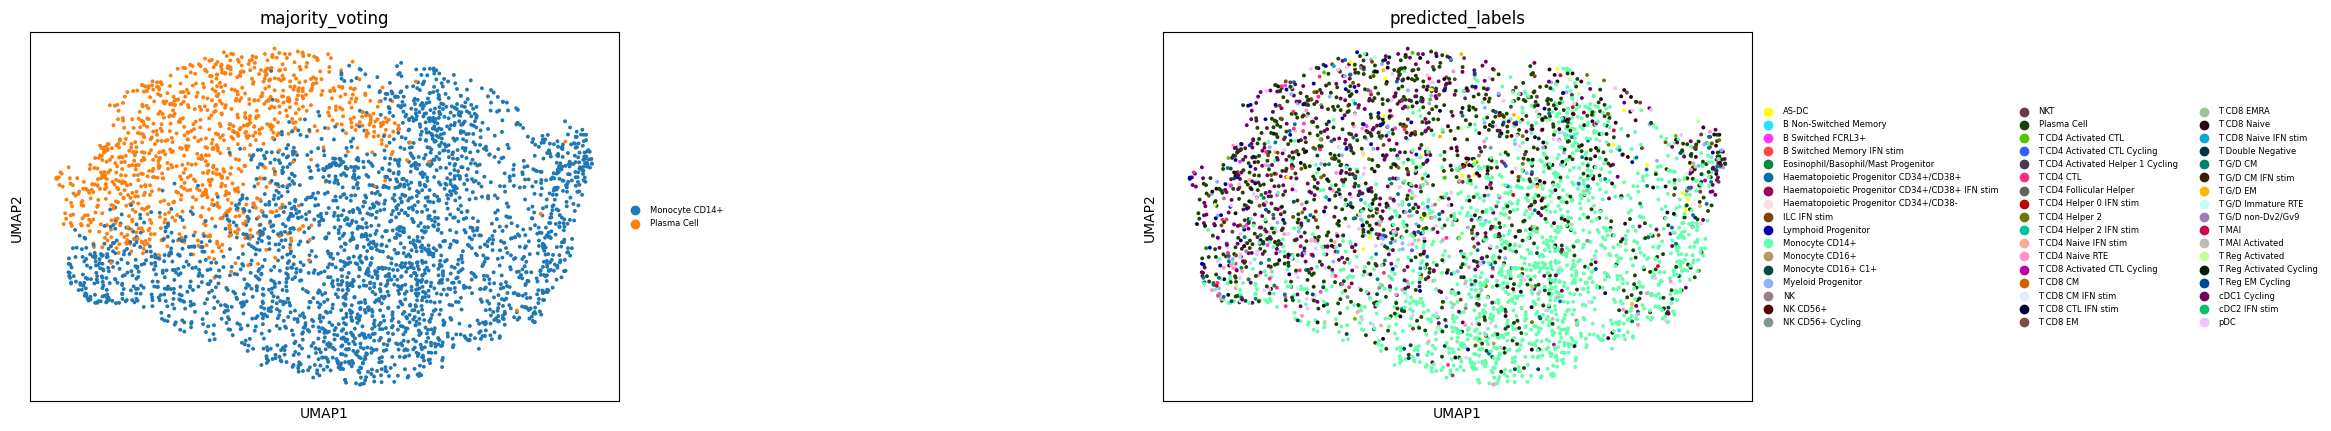

In [18]:
_ = self.annotate_clusters("COVID19_HumanChallenge_Blood.pkl")
# THIS MODEL IS JUST FOR ILLUSTRATION
# YOU SHOULD CHOOSE ONE THAT MAKES SENSE FOR YOUR DATA
self.rna.obs

# Inspection

First, you can easily print the `.adata` representation, the gene expression modality `.obs` preview, and columns and keys stored in the object's attributes using the `print()` method.

In [ ]:
self.print()

## Set Up Arguments for Later


This code looks more complicated than it actually would actually be for an end user because it was made to be generalizable across several datasets with particular column names, sizes that make it necessary to subset them in order to run the vignettes in a reasonable period of time, etc.

Basically, you won't need this code as an end user; this is just to choose random subsets of genes and perturbations, etc. that are available in a given example dataset.

In real use cases, you will know what genes and conditions are of interest, and you can manually specify them by simply stating them in the appropriate arguments (such as `target_gene_idents`) or (in many cases) by not specifying the argument (resulting in the code using all available genes, etc.).

In [ ]:
genes = self.rna.var.reset_index()[self._columns["col_gene_symbols"]]
if file == "CRISPRi_scr":
    genes_subset = [
        "CDKN2A", "CDKN1A", "PLAUR", "TP53", "IL6ST", "IL1A", "CXCL8", "CCL2", 
        "CEBPB", "NFKB1", "IGFBP7", "BCL2", "ERCC1", "ERCC4", "PTGER4", 
        "TGFB1", "ATG16L1", "NOD2", "LACC1"]
else:
    genes_subset = list(pd.Series(genes).sample(10))
target_gene_idents = list(self.obs[self._columns[
    "col_target_genes"]].sample(10))  # 10 random guide gene targets

## Explore Data Descriptives

You can plot and explore descriptives using the `describe()` method.

In [ ]:
_ = self.describe()  # simple
# _ = self.describe(group_by=self._columns["col_target_genes"], plot=True)

# Plots

Create plots applicable to scRNA-seq data broadly (e.g., UMAP, dotplots) without having to do any perturbation-specific analyses.

## Basic Usage

You can create simple plots easily without having to remember a bunch of arguments to specify! 

The most useful is the `genes` argument, which allows you to subset the number of features plotted (useful for spead and layout/interpretability of plots).

In [ ]:
# figs = self.plot(genes=["gene A", "gene B"...])  # to specify specific genes
figs = self.plot(genes=24)  # to specify random subset of this # of genes

## Advanced Usage

Use the `layers` argument to plot more layers (in this instance, all of them, including the scaled data) for certain plot types.
 
Use the `cell_types_circle` argument to create a UMAP with certain cell types circled in red.

Use the `genes_highlight` argument to highlight in gold the names of specified genes on the gene expression dot plot.

Use the `kws_clustering` argument to specify a dictionary keywords to pass to certain UMAP-based plots. For instance, specify `kws_clustering=dict(col_cell_type="leiden")` to use leiden clusters instead of whatever is stored in `self._columns["col_cell_type"]`.

Use the `kws_gex_violin` argument to pass additional arguments to the violin plots of gene expression.

In [ ]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
clus = list(self.rna.obs[cct].sample(2))  # clusters to circle
figs = self.plot(genes=36, 
                 col_cell_type=cct,
                 cell_types_circle=clus,  # list cell types to circle on UMAP
                 genes_highlight=list(np.array(genes_subset)[1:3]), 
                 kws_gex_violin=dict(scale="area", height=10),
                 kws_umap=dict(col_cell_type=cct))

# Analyses

The following examples concern CRISPR or other perturbation design-specific analyses.

## Guide RNA Counts/Percentage

In [ ]:
# Choose Subset of Target Genes (optional)
tgis = list(pd.Series(target_gene_idents).sample(3)) if len(
    target_gene_idents) > 3 else target_gene_idents  # smaller subset = faster
cct = "majority_voting" if "majority_voting" in self.rna.obs else None

# Guide RNA Counts
_ = self.get_guide_rna_counts(target_gene_idents=tgis)

# ...By Cell Type
_ = self.get_guide_rna_counts(target_gene_idents=tgis, group_by=cct)

# # ...By Target Gene Ultimately Assigned
# _ = self.get_guide_rna_counts(target_gene_idents=tgis, 
#                               group_by=self._columns["col_target_genes"])

# ...By Cell Type & Target Gene Ultimately Assigned
_ = self.get_guide_rna_counts(target_gene_idents=tgis, group_by=[
    cct, self._columns["col_target_genes"]], margin_titles=True)

## Augur: Perturbation Responses by Cell Type

**Which cell types are most affected by perturbations?** Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of experimental condition labels (e.g., treated versus untreated). The more separable the condition among cells of a given type, the higher the perturbation effect score.

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type
- Identify the most important features (genes).

<u> __Input__ </u>  

There are no required arguments. 
* If you want to override defaults drawn from `._columns` and/or `._keys`, specify the appropriate argument (e.g., `col_cell_type`). 
* You can also specify a different `classifer` (default "random_forest_classifer") used in the machine learning classification procedure used to calculate the AUCs/accuracy. 
* You may pass keyword arguments to the Augur predict method by specifying a dictionary in `kws_augur_predict`.
* Specify `select_variance_features` as True to run the original Augur implementation, which removes genes that don't vary much across cell type. If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.
* Specify `n_folds` and/or `subsample_size` to choose the number and sample size of folds in cross-validation.
* Set an integer for `seed` to allow reproducibility across runs.

<u> __Output__ </u>  

Tuple, where the first element is the AnnData object created by the function, the second, the results dictionary, and the third, a dictionary of figures visualizing results. If copy is False (default), these outputs can also be found in `.results["augur"]` and `.figures["augur"]`.

<u> __Notes__ </u>  

- Sub-sample sizes equal across conditions; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, 
    - If False, you also have to be sure that "highly_variable_features" is a variable in your data. This can be complicated if you have a separate layer for perturbation data.

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
_ = self.run_augur(
    col_cell_type=cct, 
    # ^ will be label in self._columns by default, but can override here
    col_perturbed=self._columns["col_perturbed"], 
    # ^ will be this by default if unspecified, but can override here
    key_treatment=self._keys["key_treatment"],  
    # ^ will be this by default if unspecified, but can o verride here
    select_variance_features=True,  # filter by highly variable genes
    classifier="random_forest_classifier", n_folds=3, augur_mode="default", 
    kws_umap=kws_umap, subsample_size=5, kws_augur_predict=dict(span=0.7))

## Mixscape: Cell-Level Perturbation Classification & Scoring

**Is a perturbed cell detectibly perturbed, and to what extent?** Mixscape first calculates the "**perturbation signature**" by determining which control condition cells most closely resemble each perturbed cell in terms of mRNA expression and then subtracts the control expression from that of the perturbed cells' (i.e., centers perturbed cells' gene expression on their control neighbors).

Then, it **identifies** and removes perturbed **cells with no detectible perturbation** (i.e., assigns them to predicted classes of perturbed versus not perturbed). You can then create visuals based on whether the cell is detectibly perturbed, "non-perturbed" (not detectibly perturbed), or control (no treatment). Optionally, you can visualize protein expression by this predicted class in certain multi-modal data.

**Are there perturbation-specific clusters?** Mixscape uses linear discriminant analysis (LDA) to cluster cells that resemble each other in terms of gene expression and perturbation condition. _(LDA reduces dimensionality and attempts to maximize the separability of classes. Unperturbed cells are removed from analysis.)_ 

<u> __Features__ </u>  

- Plot targeting efficiency.
- Remove confounds (e.g., cell cycle, batch effects)
- Classify cells as affected or unaffected (i.e., "escapees") by the perturbation
- Quantify and visualize degree of perturbation response

<u> __Input__ </u> 

See documentation, but the key arguments are listed here.

* **col_cell_type**: If you want to run using a different cell classification column, (e.g., CellTypist annotations that weren't used for the original `self._columns["col_cell_type"]``), you can specify a different column by passing `col_cell_type=<column name>` if you'd like.
* **target_gene_idents**: A list of gene symbols to focus on in plots/analyses. Specify as True to include all.
* **target_gene_idents**: The default layer of data used is "log1p." Remember that Mixscape centers cells on their control neighbors when considering whether to use centered and/or scaled data.

<u> __Output__ </u>  

Assuming your `Crispr` object is named "self":
- Targeting Efficiency: `self.figures["mixscape"]["targeting_efficiency"]`
- Differential Expression Ordered by Posterior Probabilities: `self.figures["mixscape"]["DEX_ordered_by_ppp_heat"]`
- Posterior Probabilities Violin Plot: `self.figures["mixscape"]["ppp_violin"]`
- Perturbation Scores: `self.figures["mixscape"]["perturbation_score"]`
- Perturbation Clusters (from LDA): `self.figures["mixscape"]["perturbation_clusters"]`

The above instructions are for accessing output via the object attributes. Assuming output is assigned to a variable `figs` (i.e., `figs = ` would replace the `_ = ` in the code below), replace `self.figures["mixscape"]` in the above code with `figs`.

<u> __Notes__ </u>  

- If `._columns["col_sample_id"]` is not None, perturbation scores will by default be calculated and/or plotted taking that into consideration (e.g., biological replicates) unless `col_split_by=False`. That argument can also be set to a different column name explicitly, in which case that specification will be used as the `col_split_by` argument in Pertpy Mixscape functions in place of sample ID.

#### Run Mixscape

In [ ]:
adata = self.rna.copy()
col_target_genes = self._columns["col_target_genes"]

nrow, ncol = cr.pl.square_grid(len(target_gene_idents))
fig, axs = plt.subplots(nrow, ncol, figsize=(50, 50))
axs = axs.flatten()
    # for i, x in enumerate(target_gene_idents):  # iterate target genes
    #     try:
    #         sc.pl.violin(
    #             adata[adata.obs[col_target_genes] == x], key=x,
    #             groupby="mixscape_class_global", ax=axs[i])
    #     except Exception as err:
    #         print(f"{err}\n\nGene expression violin plot failed for {x}!")
    #         figs[f"gex_violin_{x}"] = err

for x in ["NOD2"]:  # iterate target genes
    figs[f"gex_violin_{x}"] = sc.pl.violin(
        adata[adata.obs[col_target_genes] == x], key=x,
        groupby="mixscape_class_global")


Un-used Keyword Arguments: {'col_cell_type': 'predicted_labels', 'col_gene_symbols': 'gene_symbols', 'col_sample_id': None, 'col_batch': None, 'col_condition': 'target_gene_name', 'col_num_umis': 'num_umis', 'col_guide_split': 'guide_split', 'preprocessing': 'preprocessing', 'perturbation': 'X_pert', 'unnormalized': 'unnormalized', 'norm_total_counts': 'norm_total_counts', 'log1p': 'log1p', 'unscaled': 'unscaled', 'scaled': 'scaled', 'unregressed': 'unregressed', 'counts': 'counts', 'layer_perturbation': 'X_pert'}

<<< CALCULATING PERTURBATION SIGNATURE >>>

<<< RUNNING MIXSCAPE ROUTINE >>>


... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: NT, PTPN22 NP
var_group_labels: NT


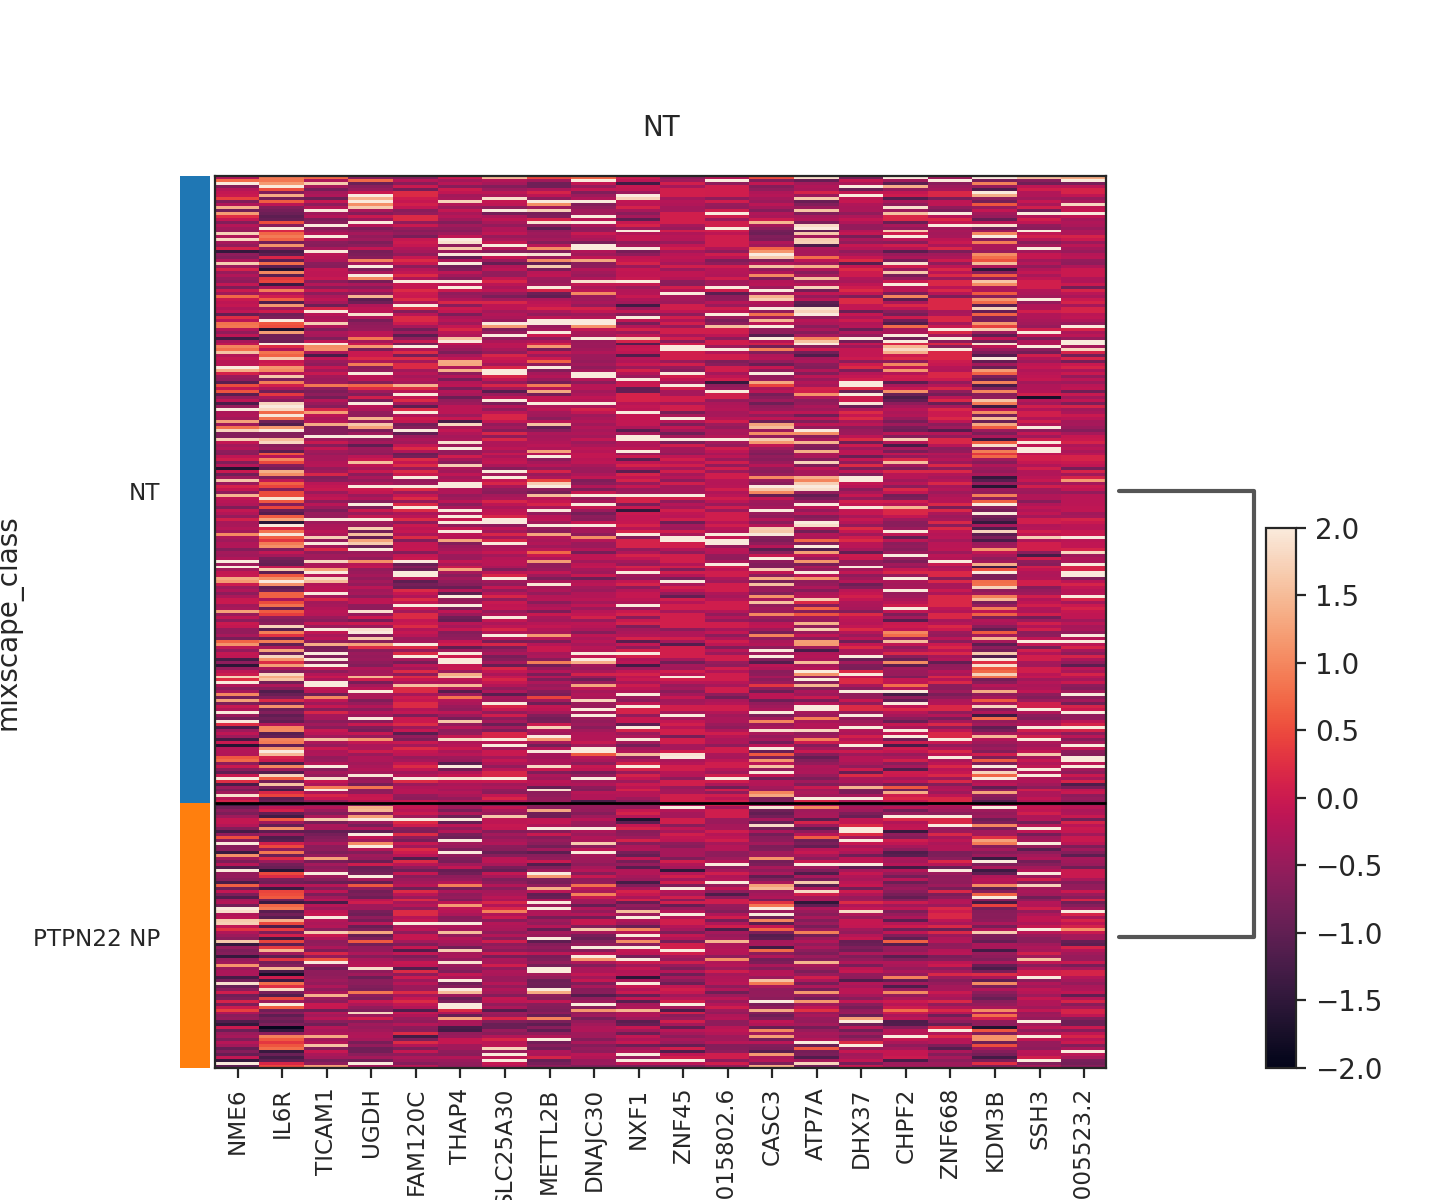

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical
... storing 'mixscape_class' as categorical


In [14]:
cct = "predicted_labels" if "predicted_labels" in self.rna.obs else None
tgis = list(self.rna.obs[self._columns["col_target_genes"]].sample(3))
_ = self.run_mixscape(col_cell_type=cct, target_gene_idents=tgis)
# _ = self.run_mixscape(target_gene_idents=True)  # plot all target genes

#### Create Different Mixscape Plots

If you want to re-create mixscape **plots with <u> different target genes and/or proteins of interest**</u> later, you can use `self.plot_mixscape(<ONE OR MORE TARGET GENES>)`. If you want a different color for the perturbation score curves, specify `color=` in that method.

In [ ]:
tgis = pd.Series(self.rna.uns["mixscape"].keys()).sample(1)
_ = self.plot_mixscape(tgis, color="red")

## Distance

Distance Metrics

See `self.figures["distances"]` and  `self.results["distances"]` for results.

In [ ]:
for x in ["mmd", "edistance"]:
    _ = self.compute_distance(distance_type=x, method="X_pca", kws_plot=dict(
        figsize=(15, 15), robust=True))

## Multi-Cellular Programs (Dialogue)

In [ ]:
cct = "majority_voting" if "majority_voting" in self.rna.obs else \
    self._columns["col_cell_type"]
fig_mcp = self.run_dialogue(n_programs=4, col_cell_type=cct, cmap="coolwarm")

# TESTING WORKSPACE (IGNORE)

In [ ]:
import scanpy as sc

sc.tl.embedding_density(self.rna, basis="umap", groupby=self._columns["col_perturbed"])
sc.pl.embedding_density(self.rna, basis="umap", key=f"umap_density_{self._columns['col_perturbed']}", group=self._keys["key_control"])
sc.pl.embedding_density(self.rna, basis="umap", key=f"umap_density_{self._columns['col_perturbed']}", group=self._keys["key_treatment"])
self.rna.obs[self._columns["col_perturbed"]].value_counts()

In [ ]:
key_treatment="KD"
key_control="NT"
col_target_genes = self._columns["col_target_genes"]
figs = {}
figs["perturbation_clusters"] = {}
color="red"
g = "LACC1"
import matplotlib.pyplot as plt

figs["perturbation_clusters"] = plt.figure(figsize=(30, 30))
axis = figs["perturbation_clusters"].add_subplot(111)
pt.pl.ms.lda(adata=self.adata, perturbation_type=key_treatment, ax=axis, 
             control=key_control)  # UMAP
figs["perturbation_clusters"].tight_layout()
figs["perturbation_clusters"].suptitle("Perturbation-Specific Clusters")
print(figs["perturbation_clusters"])